In [ ]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


from tqdm import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline     
sns.set(color_codes=True)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")


In [122]:
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [123]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [124]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df2_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df4 = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [ ]:
dffn, dffn_norm_idx = process_df_smartseq(dffn.copy(), df_meta, "MCF7_")
df2fn, df2fn_norm_idx = process_df_smartseq(df2fn.copy(), df2_meta, "HCC1806_")
df3, df3_norm_idx = process_df_dropseq(df3, "MCF7_")
df4, df4_norm_idx = process_df_dropseq(df4, "HCC1806_")

In [ ]:
df3

In [ ]:
df_drop_norm_idx = np.concatenate([df3_norm_idx, df4_norm_idx])
df_smart_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx])
df_smart_idx = np.concatenate([dffn.index, df2fn.index])

df_all = pd.concat([dffn, df2fn, df3, df4])
df_all = df_all.fillna(0)

df_all_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx])

df_MCF7_idx = [idx for idx in df_all.index if "MCF7" in idx]


In [ ]:
df_all["mcf"] = ["MCF7" in idx for idx in df_all.index]
df_all["smart"] = [idx in df_smart_idx for idx in df_all.index]

In [ ]:
df_all = df_all.astype(np.int32)

In [125]:
# Free up memory
del dffn, df2fn, df3, df4, dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx, df_meta, df2_meta

NameError: name 'dffn_norm_idx' is not defined

In [126]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

# Define the architecture of the autoencoder
class NNClassifier(nn.Module):
    def __init__(self, in_size, H1, H2, H3):
        super(NNClassifier, self).__init__()

        self.layers = nn.Sequential(
            KANLinear(in_size, H1),
            nn.Dropout(0.5),
            KANLinear(H1, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H2),
            nn.Dropout(0.5),
            KANLinear(H2, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, H3),
            nn.Dropout(0.5),
            KANLinear(H3, 1))

    def forward(self, x):
        return self.layers(x)

In [127]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)


@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted +0.5 > labels).sum().item()
        y_pred_class.extend(predicted.cpu().round()) # Save Prediction
        y_pred.extend(predicted.cpu()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    print("F1 Score:", f1_score(y_true, y_pred_class))
    print("Recall:", recall_score(y_true, y_pred_class))
    print(f'Accuracy of the network on the {total} test images: {(correct / total) * 100}%')


In [128]:
input_size = df_all.shape[1]
learning_rate = 1e-2

hidden_size = 1024
hidden_size1 = 512
hidden_size2 = 256

test_amount = 0.2

In [ ]:
df_train, df_test = train_test_split(df_all, test_size=test_amount, stratify=df_all.index.isin(df_all_norm_idx))

In [ ]:
df_train_smart = df_train[[i in df_smart_idx for i in df_train.index]]
df_train_drop = df_train[[i not in df_smart_idx for i in df_train.index]]

dataset = NNDataset(df_train, df_all_norm_idx)
dataset_drop = NNDataset(df_train_drop, df_all_norm_idx)
dataset_smart = NNDataset(df_train_smart, df_all_norm_idx)

data_loader = DataLoader(dataset, batch_size=128, shuffle=True)
data_loader_drop = DataLoader(dataset_drop, batch_size=128, shuffle=True)
data_loader_smart = DataLoader(dataset_smart, batch_size=32, shuffle=True)

In [ ]:
dataset_test = NNDataset(df_test, df_all_norm_idx)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

df_test_smart = df_test[[i in df_smart_idx for i in df_test.index]]
df_test_drop = df_test[[i not in df_smart_idx for i in df_test.index]]

dataset_test_smart = NNDataset(df_test_smart, df_smart_norm_idx)
dataset_test_drop = NNDataset(df_test_drop, df_drop_norm_idx)

test_loader_smart = DataLoader(dataset_test_smart, batch_size=64, shuffle=True)
test_loader_drop = DataLoader(dataset_test_drop, batch_size=64, shuffle=True)

In [129]:
# Define the model
model = NNClassifier(input_size, hidden_size, hidden_size1, hidden_size2).to(device)
writer = SummaryWriter()

In [130]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()


In [131]:
lr_sgd = 1e-2
lr_adm = 1e-3
lr_ada = 1e-2
lr_admw = 1e-3
wd_admw = 1e-4

# Define the optimizer
sgd = optim.SGD(model.parameters(), lr=lr_sgd)
adm = optim.Adam(model.parameters(), lr=lr_adm)
ada = optim.Adagrad(model.parameters(), lr=lr_ada)
admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

In [132]:
model

NNClassifier(
  (layers): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): Dropout(p=0.5, inplace=False)
    (2): KANLinear(
      (base_activation): SiLU()
    )
    (3): Dropout(p=0.5, inplace=False)
    (4): KANLinear(
      (base_activation): SiLU()
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): KANLinear(
      (base_activation): SiLU()
    )
    (7): Dropout(p=0.5, inplace=False)
    (8): KANLinear(
      (base_activation): SiLU()
    )
    (9): Dropout(p=0.5, inplace=False)
    (10): KANLinear(
      (base_activation): SiLU()
    )
    (11): Dropout(p=0.5, inplace=False)
    (12): KANLinear(
      (base_activation): SiLU()
    )
  )
)

In [139]:
train_config = [
    #[5, data_loader, admw],
    #[100, data_loader_smart, admw],
    #[10, data_loader_drop, admw],
    [10, data_loader, ada]
]

In [134]:
total_epochs = 0
# Training loop
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for inputs, labels in data_loaderr:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs[:, 0], labels)

            # Backward pass and optimize
            loss.backward()

            # Clip gradients
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Print statistics
            running_loss += loss.item()

        writer.add_scalar("Loss/train", running_loss/len(data_loader), epoch)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(data_loader)}", flush=True)
        measure_model_log(writer, model, test_loader, total_epochs)
        writer.flush()
        total_epochs += 1

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 1.7166516889858505


 10%|█         | 1/10 [00:32<04:56, 32.98s/it]

F1 Score: 0.9615170105967652
Recall: 0.9607132906101978
Accuracy on test: 96.24387588459444%
Epoch 2, Loss: 0.2694588975009063


 20%|██        | 2/10 [01:05<04:23, 32.99s/it]

F1 Score: 0.9705679148818571
Recall: 0.9785455558651435
Accuracy on test: 97.1012520413718%
Epoch 3, Loss: 0.12117850319684847


 30%|███       | 3/10 [01:38<03:50, 32.96s/it]

F1 Score: 0.9713331477873643
Recall: 0.9724157146837559
Accuracy on test: 97.1965160587915%
Epoch 4, Loss: 0.09130795563206724


 40%|████      | 4/10 [02:11<03:17, 32.94s/it]

F1 Score: 0.9708111142295818
Recall: 0.9637782112008916
Accuracy on test: 97.16929776810017%
Epoch 5, Loss: 0.0496516864038194


 50%|█████     | 5/10 [02:44<02:44, 32.92s/it]

F1 Score: 0.9718841796055392
Recall: 0.9679576483700195
Accuracy on test: 97.26456178551986%


 50%|█████     | 5/10 [02:55<02:55, 35.04s/it]


KeyboardInterrupt: 

F1 Score: 0.9699775533108866
Recall: 0.9632209529116745
Accuracy of the network on the 7348 test images: 98.20359281437125%


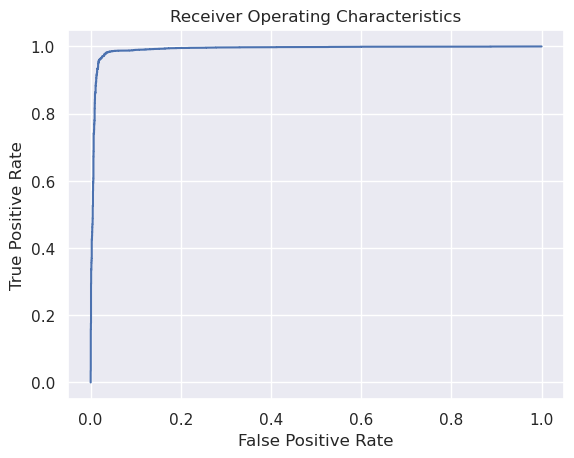

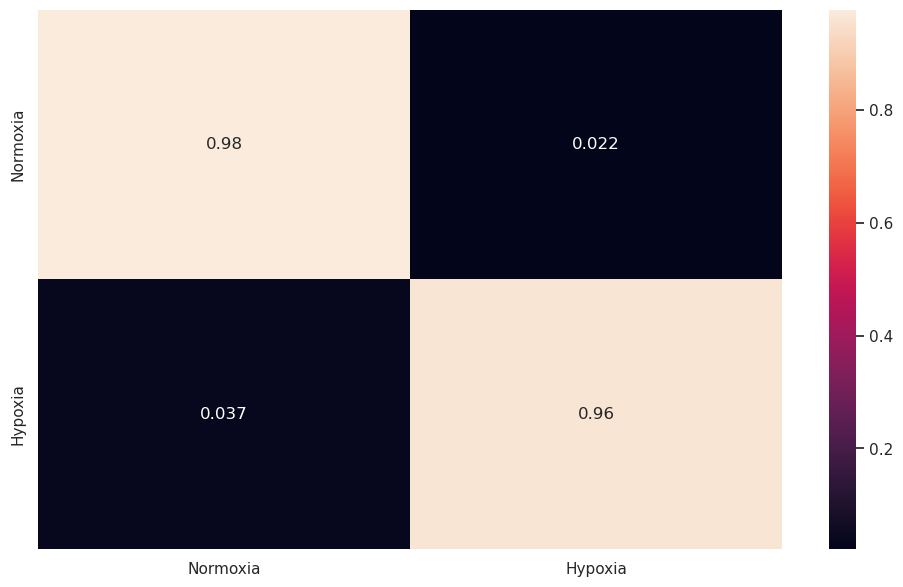

In [135]:
measure_model(model, test_loader)

F1 Score: 0.9736842105263158
Recall: 0.9487179487179487
Accuracy of the network on the 86 test images: 97.67441860465115%


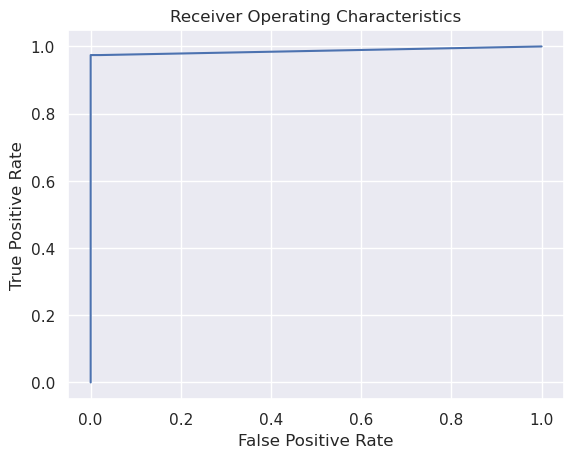

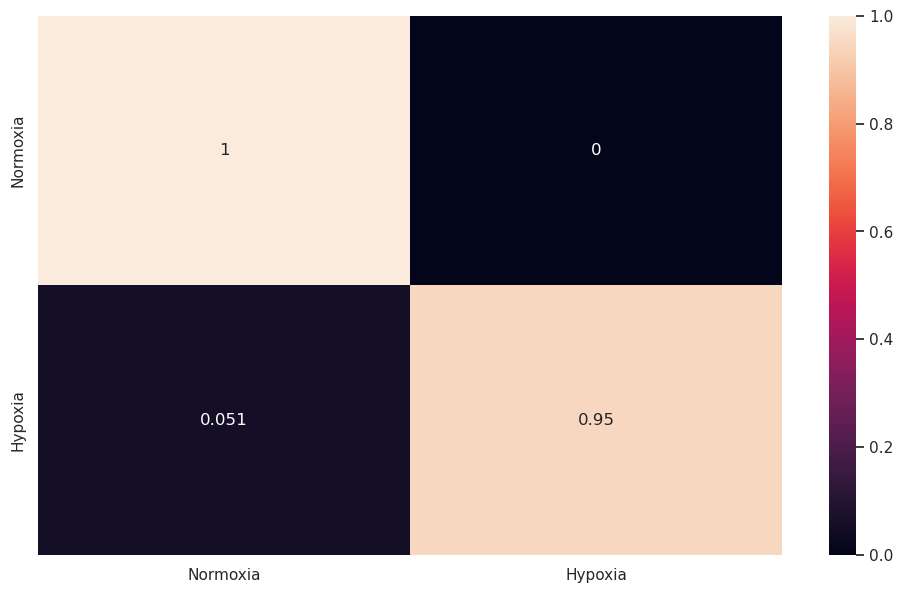

In [136]:
measure_model(model, test_loader_smart)

F1 Score: 0.97105561861521
Recall: 0.963943661971831
Accuracy of the network on the 7262 test images: 98.23740016524374%


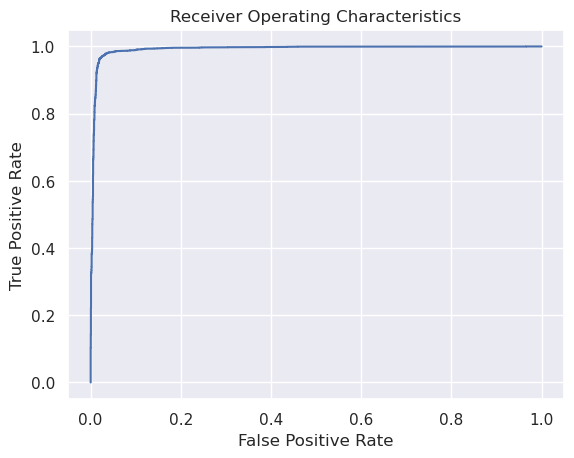

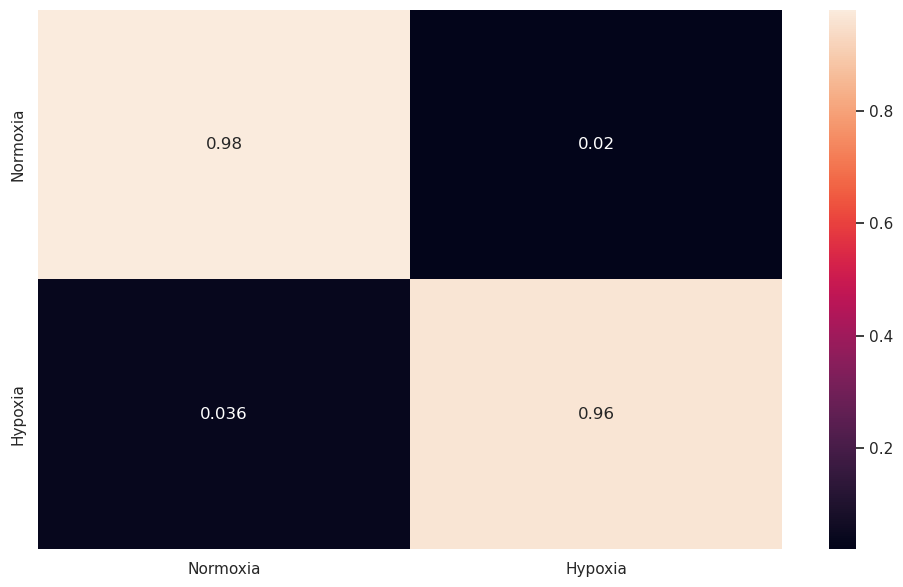

In [137]:

measure_model(model, test_loader_drop)

In [ ]:
torch.save(model.state_dict(), "KAN_SMART_HCC_2.checkpoint")

In [121]:
import gc

model.cpu()
del model, admw
gc.collect()
torch.cuda.empty_cache()